In [1]:
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm.notebook import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint


In [4]:
class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y, A)


In [5]:
def get_batch(y, t, batch_time=8, batch_size=256):
    size = len(t)
    start = np.random.randint(size-batch_time, size=batch_size)
    y0 = y[start]
    t0 = np.random.randint(size-batch_time)
    ts = t[t0:t0+batch_time]
    ys = torch.stack([y[start + i] for i in range(batch_time)], dim=0)
    return y0, ts, ys


In [6]:
class ODEF(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Linear(2, 2, bias=False)
        nn.init.normal_(self.net.weight)

    def forward(self, t, y):
        return self.net(y)


In [7]:
def plot(func, y, y0, t, epoch: int = None):
    y_pred = odeint(func, y0, t, method='rk4')[:, 0]

    plt.figure(figsize=(12, 3))

    ax = plt.subplot(1, 3, 1)
    ax.set_title('Фазовый портрет')
    ax.plot(y_pred.detach()[:, 0].cpu(), y_pred.detach()[:, 1].cpu(), c='r')
    ax.scatter(y.detach()[:, 0].cpu(), y.detach()[:, 1].cpu(), s=1, c='k', alpha=0.7)
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')

    ax = plt.subplot(1, 3, 2)
    ax.set_title('Траектории')
    ax.plot(t.cpu(), y_pred.detach()[:, 0].cpu())
    ax.plot(t.cpu(), y_pred.detach()[:, 1].cpu())
    ax.scatter(t.cpu(), y.detach()[:, 0].cpu(), s=1, alpha=0.7)
    ax.scatter(t.cpu(), y.detach()[:, 1].cpu(), s=1, alpha=0.7)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$y_1$, $y_2$')
    ax.set_xlim(t.cpu().min(), t.cpu().max())
    ax.set_ylim(-1, 1)

    ax = plt.subplot(1, 3, 3)
    Y, X = np.mgrid[-1:1:21j, -1:1:21j]
    dydt = func(0, torch.Tensor(np.stack([X, Y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
    mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
    dydt = (dydt / mag)
    dydt = dydt.reshape(21, 21, 2)

    ax.set_title('Векторное поле обучения')
    ax.streamplot(X, Y, dydt[:, :, 0], dydt[:, :, 1], color="black")
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

    plt.tight_layout()
    if epoch is None:
        plt.show();
    else:
        plt.savefig('imgs/{:04d}'.format(epoch));
        plt.clf();
        plt.close();


In [8]:
Path('imgs').mkdir(exist_ok=True)

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y0 = torch.Tensor([[0.6, 0.3]]).to(device)
t = torch.linspace(0., 20., 200).to(device)
A = torch.Tensor([[-0.1, -1.], [1., -0.1]]).to(device)

y = odeint(Lambda(), y0, t, method='rk4')[:, 0]
y = y + 0.01 * torch.randn(y.size(), device=device)

epoches = 500
func = ODEF().to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

pbar = tqdm(total=epoches)

with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        y0, ts, ys = get_batch(y, t)
        y_pred = odeint(func, y0, ts, method='rk4').to(device)
        loss = torch.mean(torch.abs(y_pred - ys))
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))

        with torch.no_grad():
            if (i % 20) == 0:
                y0 = torch.Tensor([[0.6, 0.3]]).to(device)
                plot(func, y, y0, t, i);

    with torch.no_grad():
        y0 = torch.Tensor([[0.6, 0.3]]).to(device)
        plot(func, y, y0, t, epoches);

images = []
filenames = sorted(list(Path('imgs/').glob('*.png')))
for filename in filenames:
    images.append(imageio.imread(str(filename)))
imageio.mimsave('simple_ode.gif', images, duration=5, format='GIF')
shutil.rmtree('imgs')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


![alt](simple_ode.gif)

In [19]:
def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


In [113]:
class CNF(nn.Module):

    def __init__(self, inp: int, width: int):
        super().__init__()

        self.u = nn.Parameter(torch.randn(width, 1, inp) * 0.01)
        self.w = nn.Parameter(torch.randn(width, inp, 1) * 0.01)
        self.b = nn.Parameter(torch.randn(width, 1, 1) * 0.01)

    def forward(self, t, state):
        z = state[0]
        logp_z = state[1]
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            dz_dt = torch.matmul(torch.tanh(torch.matmul(z, self.w) + self.b), self.u).mean(0)
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(z.size(0), 1)
            # psi = self.h_prime(affine) * self.w
            # dlogp_z_dt = -torch.log(torch.abs(psi @ u_hat.t() + 1) + 1e-8)

        return (dz_dt, dlogp_z_dt)


In [143]:
class CNF(nn.Module):

    def __init__(self, inp: int, width: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(inp, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, inp),
        )

    def forward(self, t, state):
        z = state[0]
        logp_z = state[1]
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            #dz_dt = torch.matmul(torch.tanh(torch.matmul(z, self.w) + self.b), self.u).mean(0)
            dz_dt = self.net(z)
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(z.size(0), 1)
            # psi = self.h_prime(affine) * self.w
            # dlogp_z_dt = -torch.log(torch.abs(psi @ u_hat.t() + 1) + 1e-8)

        return (dz_dt, dlogp_z_dt)


In [144]:
from sklearn.datasets import make_moons

def get_batch(num_samples):
    points, _ = make_moons(n_samples=num_samples, noise=0.06)
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    return(x, logp_diff_t1)


In [178]:
epoches = 1000
t0, t1 = 0, 1
func = CNF(2, 16).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[1., 0.0], [0.0, 1.]]).to(device)
    )
pbar = tqdm(total=epoches)
total_loss = []
with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        x, logp_diff_t1 = get_batch(512)
        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.linspace(t1, t0, 10).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='rk4',
            adjoint_method='rk4'
        )
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
        loss = -logp_x.mean(0)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))
        total_loss.append(loss.item())


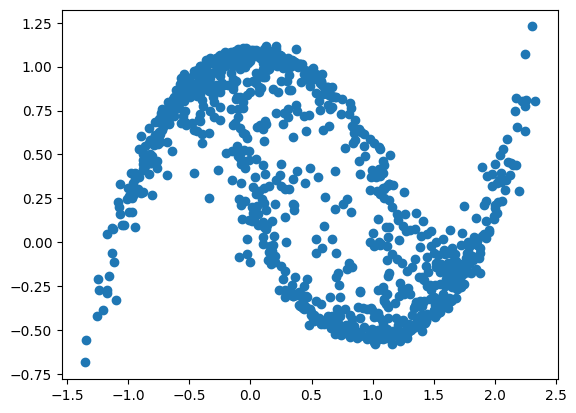

In [179]:
z = p_z0.sample((1000, )).to(device)
logp_diff_t = torch.zeros(1000, 1).to(device)
x, _ = odeint(
    func,
    (z, logp_diff_t),
    torch.linspace(t0, t1, 10).type(torch.float32).to(device),
    atol=1e-5,
    rtol=1e-5,
    method='euler',
)
x = x.detach().cpu().clone()

plt.scatter(x[-1, :, 0], x[-1, :, 1])
plt.show()


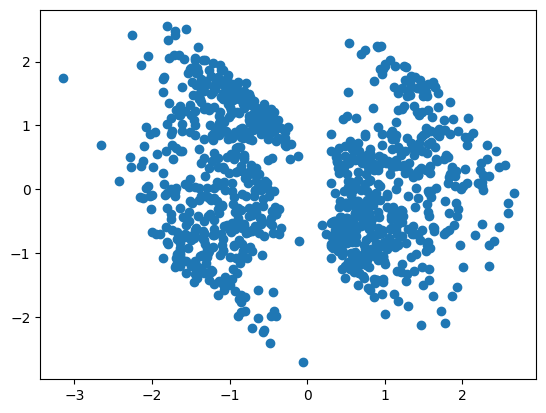

In [180]:
x, logp_diff_t1 = get_batch(1000)
x, _ = odeint(
    func,
    (x, logp_diff_t1),
    torch.linspace(t1, t0, 10).type(torch.float32).to(device),
    atol=1e-5,
    rtol=1e-5,
    method='euler',
)
x = x.detach().cpu().clone()

plt.scatter(x[-1, :, 0], x[-1, :, 1])
plt.show()


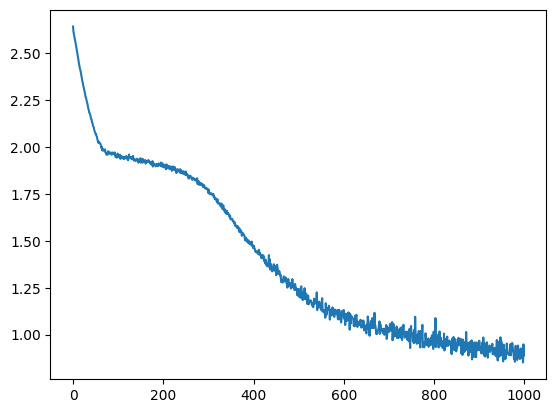

In [181]:
plt.plot(total_loss)
plt.show()
